IMAGE CLASSIFICATION WITH KERAS AND TENSORFLOW

Project Overview:
Cats and dogs are the most common animal companions in human life.
I wrote an algorithm that can distunguish between cats and dogs with the help of Keras and Tensorflow.

In [14]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import os
import zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Firstly, I unzipped the dataset I downloaded from Kaggle
https://www.kaggle.com/datasets/erkamk/cat-and-dog-images-dataset

In [15]:
with zipfile.ZipFile('archive.zip', 'r') as file:
    file.extractall()

I writed a script to read the images and their labels into memory. I resized images to (64, 64) and I normalized the pixel values.

In [16]:
def load_images_and_labels(directory, target_size=(64, 64)):
    images = []
    labels = []
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                
                image = Image.open(image_path)
                image = image.resize(target_size)
                image = np.array(image)
                
                #normalizing pixels
                image = image / 255.0
                
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

dataset_directory = "Dog and Cat .png"

images, labels = load_images_and_labels(dataset_directory)

I divided the data into training, validation and test sets. I used LabelEncoder() because of an error.

In [17]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

test_size = 0.2
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=(test_size + val_size), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(val_size / (test_size + val_size)), random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (699, 64, 64, 3)
y_train shape: (699,)
X_val shape: (200, 64, 64, 3)
y_val shape: (200,)
X_test shape: (101, 64, 64, 3)
y_test shape: (101,)


I created my model. I chosed 'adam' for optimizer (I tried RMSprop too), binary_crossentropy for loss function and 'accuracy' for metrics.

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
          

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 128)        

I fit the training data and prevented extra learning with the EarlyStopping function. I used the validation data to monitor performance.

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Accuracy: {test_acc}')

Epoch 1/100
22/22 [==============================] - 1s 55ms/step - loss: 0.3929 - accuracy: 0.8298 - val_loss: 0.6115 - val_accuracy: 0.6400
Epoch 2/100
22/22 [==============================] - 1s 56ms/step - loss: 0.3346 - accuracy: 0.8670 - val_loss: 0.6140 - val_accuracy: 0.6300
Epoch 3/100
22/22 [==============================] - 1s 51ms/step - loss: 0.3320 - accuracy: 0.8670 - val_loss: 0.5926 - val_accuracy: 0.7000
Epoch 4/100
22/22 [==============================] - 1s 51ms/step - loss: 0.3061 - accuracy: 0.8755 - val_loss: 0.6009 - val_accuracy: 0.7000
Epoch 5/100
22/22 [==============================] - 1s 54ms/step - loss: 0.3086 - accuracy: 0.8784 - val_loss: 0.5850 - val_accuracy: 0.6700
Epoch 6/100
22/22 [==============================] - 1s 55ms/step - loss: 0.2455 - accuracy: 0.9013 - val_loss: 0.5882 - val_accuracy: 0.6850
Epoch 7/100
22/22 [==============================] - 1s 51ms/step - loss: 0.2262 - accuracy: 0.9199 - val_loss: 0.5761 - val_accuracy: 0.7200
Epoch 

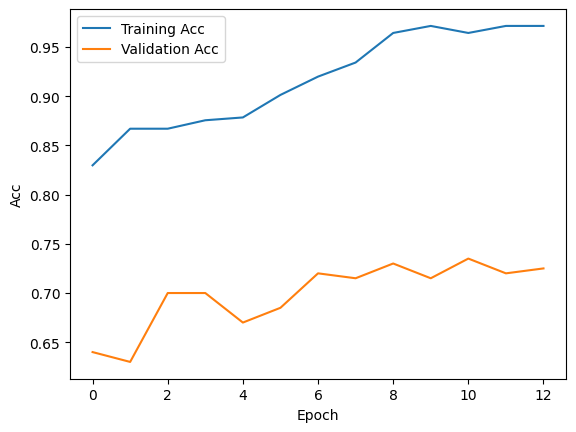

In [23]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

I used my model to make predictions on test set, and plotted results.

4/4 [==============================] - 0s 12ms/step
Example 1: Predicted Class: 0, True Class: 0
Example 2: Predicted Class: 0, True Class: 1
Example 3: Predicted Class: 0, True Class: 1
Example 4: Predicted Class: 1, True Class: 1
Example 5: Predicted Class: 1, True Class: 0


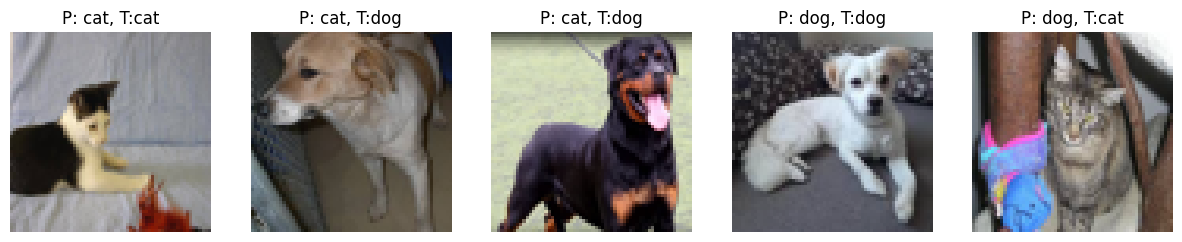

In [24]:
predictions = model.predict(X_test)

#threshold 0.5 convert them into binary classes
binary_predictions = (predictions > 0.5).astype(int)

num_images = min(5, len(X_test))

fig, axes = plt.subplots(1, num_images, figsize=(15,15))

for i in range(num_images):
    predicted_class = binary_predictions[i][0]
    true_class = y_test[i]
    
    print(f"Example {i+1}: Predicted Class: {predicted_class}, True Class: {true_class}")
    
    if predicted_class == 0:
        pred_class = 'cat'
    elif predicted_class == 1:
        pred_class = 'dog'   
    
    if true_class == 0:
        t_class = 'cat'
    elif true_class == 1:
        t_class = 'dog'
    
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"P: {pred_class}, T:{t_class}")
    axes[i].axis('off')